# Part Two - SARIMA On Monthly Sales & Monthly Profits

**Background:**

1000ml Retail wants help forecasting their Q3 sales and profit.

**Objective:**
They would like to know sales and profit by category by month.

**Deliverable:**
A 10 min presentation outlining your methodology, reasoning and findings to the (global) sales team.

This presentation should provide actionable information.

# References

* [School Years In Different Countries](https://www.infoplease.com/world/world-statistics/school-years-around-world)
* Angloinfo website has been helpful for school years. Quarter three (Q3) is July, August and September which is back to school season for many countries.

In [0]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.api as sm

In [3]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Load in data with pandas.

retail_data = pd.read_csv('/content/gdrive/My Drive/1000mlRetail.csv')

# Preview retail data.
retail_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2016-124891,2016-07-31,2016-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2017-77878,2017-02-05,2017-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2017-71249,2017-10-17,2017-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2017-1579342,2017-01-28,2017-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2017-4320,2017-11-05,2017-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


## Convert Times To DateTime

In [0]:
retail_data['Order Date'] = pd.to_datetime(retail_data['Order Date'])

retail_data['Ship Date'] = pd.to_datetime(retail_data['Ship Date'])

In [6]:
# Check that Order Date & Ship Date are indeed datetimes.

retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
Row ID            51290 non-null int64
Order ID          51290 non-null object
Order Date        51290 non-null datetime64[ns]
Ship Date         51290 non-null datetime64[ns]
Ship Mode         51290 non-null object
Customer ID       51290 non-null object
Customer Name     51290 non-null object
Segment           51290 non-null object
City              51290 non-null object
State             51290 non-null object
Country           51290 non-null object
Postal Code       9994 non-null float64
Market            51290 non-null object
Region            51290 non-null object
Product ID        51290 non-null object
Category          51290 non-null object
Sub-Category      51290 non-null object
Product Name      51290 non-null object
Sales             51290 non-null float64
Quantity          51290 non-null int64
Discount          51290 non-null float64
Profit            51290 non-null fl

In [7]:
# Look at Order Date info.

retail_data['Order Date'].describe()

count                   51290
unique                   1430
top       2018-06-18 00:00:00
freq                      135
first     2015-01-01 00:00:00
last      2018-12-31 00:00:00
Name: Order Date, dtype: object

In [8]:
# Look at Ship Date info.

retail_data['Ship Date'].describe()

count                   51290
unique                   1460
top       2018-11-22 00:00:00
freq                      130
first     2015-01-01 00:00:00
last      2018-12-31 00:00:00
Name: Ship Date, dtype: object

In [0]:
# Trying groupby on datetimes:
# Obtain counts for each month
# Reference: https://stackoverflow.com/questions/18233107/pandas-convert-datetime-to-end-of-month

retail_data['Order_Date_Month'] = retail_data['Order Date'].astype('datetime64[M]')

## A Look At Profits

In [10]:
# Profit Column

retail_data['Profit'].describe()

count    51290.000000
mean        28.610982
std        174.340972
min      -6599.978000
25%          0.000000
50%          9.240000
75%         36.810000
max       8399.976000
Name: Profit, dtype: float64

### Profits Per Month 

Profits are the sales minus the costs. Investigating the amount of profits over time for each month.

In [0]:
# Group by Month and find total profit for each month:

order_profits_monthly = retail_data.groupby(['Order_Date_Month'])['Profit'].sum()

In [12]:
order_profits_monthly.head()

Order_Date_Month
2015-01-01     8321.80096
2015-02-01    12417.90698
2015-03-01    15303.56826
2015-04-01    12902.32438
2015-05-01    12183.82870
Name: Profit, dtype: float64

Text(0.5, 1.0, 'Monthly Profits On Orders\n')

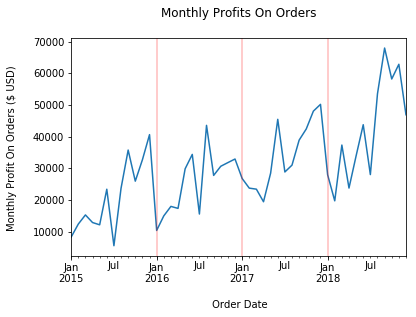

In [13]:
# Monthly Profits On Orders Plot

order_profits_monthly.plot()
plt.xlabel('\n Order Date')
plt.ylabel('Monthly Profit On Orders ($ USD) \n')
# Vertical lines at start of each year
plt.axvline(x = '2016-01-01', linewidth=2, color='red', alpha = 0.2) 
plt.axvline(x = '2017-01-01', linewidth=2, color='red', alpha = 0.2)
plt.axvline(x = '2018-01-01', linewidth=2, color='red', alpha = 0.2)

plt.title('Monthly Profits On Orders\n')

# ARIMA Model Fit & Forecasting On Monthly Profits (*)

## Train-Test Split

In [14]:
# Training data is monthly profits from 2015 - 2017 

order_profits_mth_train = order_profits_monthly[order_profits_monthly.index < '2018-01-01']

order_profits_mth_train.tail()

Order_Date_Month
2017-08-01    31023.66846
2017-09-01    38905.66778
2017-10-01    42433.22258
2017-11-01    48062.99670
2017-12-01    50202.87112
Name: Profit, dtype: float64

In [15]:
# Test set is the 2018 year only.

order_profits_mth_test = order_profits_monthly[~(order_profits_monthly.index < '2018-01-01')]

order_profits_mth_test.head()

Order_Date_Month
2018-01-01    28001.38626
2018-02-01    19751.69996
2018-03-01    37357.26052
2018-04-01    23782.30120
2018-05-01    33953.55774
Name: Profit, dtype: float64

## `auto.arima` For Model Selection

In [16]:
pip install pyramid-arima

     |████████████████████████████████| 604kB 2.8MB/s 


In [17]:
from pyramid.arima import auto_arima

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a pac

In [18]:
# Using auto arima with Adj Dickey-Fuller stationariy test and BIC criterion.
# Got SARIMA(1, 0, 0)(0, 0, 0, 12)

auto_arima(order_profits_mth_train, test =  'adf', m = 12, stepwise = True, trace = True,
           information_criterion = 'bic')

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to s

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=779.913, BIC=783.080, Fit time=0.047 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=771.160, BIC=777.494, Fit time=0.077 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=772.506, BIC=777.257, Fit time=0.015 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=772.691, BIC=779.025, Fit time=0.033 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=772.691, BIC=779.025, Fit time=0.037 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=774.053, BIC=781.970, Fit

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

In [19]:
# Using auto arima with Adj Dickey-Fuller stationariy test and AIC criterion.
# Got SARIMA(3, 0, 0)(1, 0, 0, 12)

auto_arima(order_profits_mth_train, test =  'adf', m = 12, stepwise = True, trace = True,
           information_criterion = 'aic')

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=779.913, BIC=783.080, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=771.160, BIC=777.494, Fit time=0.051 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=772.506, BIC=777.257, Fit time=0.017 seconds


/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starti

Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=772.981, BIC=780.898, Fit time=0.168 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=781.257, BIC=786.007, Fit time=0.180 seconds


/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/

Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=770.936, BIC=778.854, Fit time=0.087 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=771.186, BIC=780.687, Fit time=0.136 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(3, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=769.997, BIC=781.082, Fit time=0.203 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=773.134, BIC=782.635, Fit time=0.054 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(3, 0, 1) seasonal_order=(2, 0, 0, 12); AIC=771.878, BIC=784.546, Fit time=0.419 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds


/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 1) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 1) seasonal_order=(2, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(4, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=772.123, BIC=784.791, Fit time=0.232 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=769.929, BIC=779.430, Fit time=0.100 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=772.259, BIC=780.177, Fit time=0.034 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(3, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=771.920, BIC=783.004, Fit time=0.259 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=771.057, BIC=782.142, Fit time=0.141 seconds
Total fit time: 2.128 seconds


/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 0) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 0) seasonal_order=(2, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(1, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

Changing between AIC and BIC gives a different (suggested) model output. 


### Trying auto.arima with kpss Test and BIC

In [20]:
# Using auto arima with kpss stationariy test and BIC criterion.
# Got SARIMA(2, 1, 0)(0, 0, 0, 12)

auto_arima(order_profits_mth_train, test =  'kpss', m = 12, stepwise = True, trace = True,
           information_criterion = 'bic')

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=756.449, BIC=759.559, Fit time=0.007 seconds


/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 0) seasonal_order=(1, 0, 1, 12); data is likel

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=751.275, BIC=757.497, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=750.796, BIC=755.462, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=747.515, BIC=753.737, Fit time=0.020 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=749.409, BIC=757.186, Fit time=0.042 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=751.279, BIC=760.611, Fit time=0.068 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=748.314, BIC=756.091, Fit time=0.084 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, F

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 0) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

## Model Fit On Profits SARIMA(1, 0, 0)(0, 0, 0, 12)

In [0]:
import statsmodels.api as sm

In [22]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

sarima_100_profit_train = sm.tsa.statespace.SARIMAX(order_profits_mth_train,
                                       order = (1, 0, 0),
                                       seasonal_order = (0, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_100_profit_train = sarima_100_profit_train.fit()

print(results_100_profit_train.summary())

                           Statespace Model Results                           
Dep. Variable:                 Profit   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -376.275
Date:                Mon, 23 Sep 2019   AIC                            756.549
Time:                        00:29:27   BIC                            759.660
Sample:                    01-01-2015   HQIC                           757.623
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9635      0.064     15.076      0.000       0.838       1.089
sigma2      1.275e+08   4.95e-11   2.57e+18      0.000    1.27e+08    1.27e+08
Ljung-Box (Q):                         nan   Jarque-

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


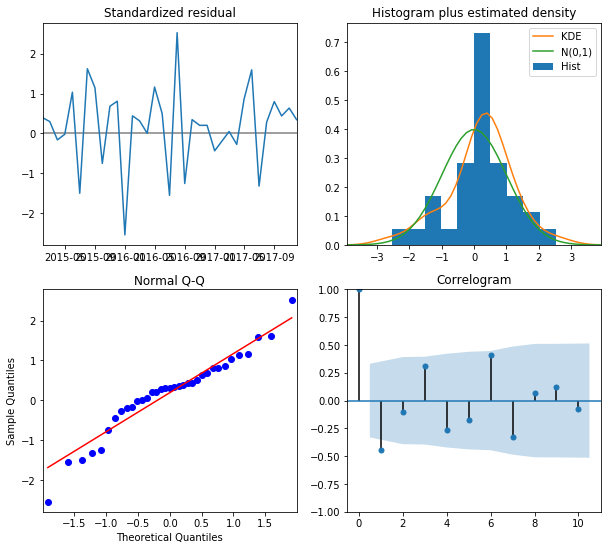

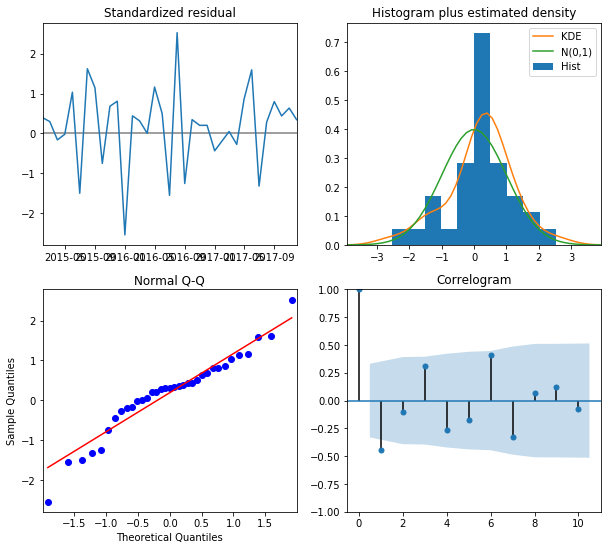

In [23]:
# Model Diganostics or SARIMA(2, 1, 1) on training set for monthly profits.
# Residuals look okay. 

results_100_profit_train.plot_diagnostics(figsize = (10, 9))

## Forecasting On Profits SARIMA(1, 0, 0)(0, 0, 0, 12)

In [24]:
# Obtain forecasts for 2018 from SARIMA(1, 0, 0)(0, 0, 0, 12)

forecasts_profits100 = results_100_profit_train.get_forecast(steps = 12)

forecasts_profits100.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,48372.405326,11291.014807,26242.422956,70502.387696
2018-02-01,46608.680834,15679.502922,15877.419813,77339.941856
2018-03-01,44909.264166,18860.881141,7942.616413,81875.911920
2018-04-01,43271.810569,21395.133966,1338.118551,85205.502587
2018-05-01,41694.060784,23504.612401,-4374.132992,87762.254561
2018-06-01,40173.837929,25306.143247,-9425.291423,89772.967281
2018-07-01,38709.044492,26870.792228,-13956.740512,91374.829495
2018-08-01,37297.659440,28245.942827,-18063.371210,92658.690089
2018-09-01,35937.735430,29465.246761,-21813.087017,93688.557876
2018-10-01,34627.396121,30553.729814,-25256.813907,94511.606150


In [25]:
# Obtain means from forecasts:

forecasts_mean_profits100 = forecasts_profits100.summary_frame()['mean']

forecasts_mean_profits100

2018-01-01    48372.405326
2018-02-01    46608.680834
2018-03-01    44909.264166
2018-04-01    43271.810569
2018-05-01    41694.060784
2018-06-01    40173.837929
2018-07-01    38709.044492
2018-08-01    37297.659440
2018-09-01    35937.735430
2018-10-01    34627.396121
2018-11-01    33364.833588
2018-12-01    32148.305823
Freq: MS, Name: mean, dtype: float64

### RMSE, Correlation & Mean Abs. Pct Error

In [26]:
# Root Mean Squared Error - Square of Predictions - Acutal (Test) Values:

mse_profit_100 = np.mean((forecasts_mean_profits100 - order_profits_mth_test)**2)

rmse_profit_100 = mse_profit_100 ** 0.5

rmse_profit_100

19779.093054419616

In [27]:
# Correlation Between Forecasted 2018 Values & Actual 2018 Sales Per Month

corr_profits_100 = np.corrcoef(forecasts_mean_profits100, order_profits_mth_test)

corr_profits_100

array([[ 1.        , -0.79088522],
       [-0.79088522,  1.        ]])

I have a (borderline) strong negative correlation between the forecasted values for 2018 and the test values. This is bad. Reject this model.

In [28]:
# Mean Absolute Percentage Error

mean_abs_percent_error_profits_100 = np.mean(np.abs(forecasts_mean_profits100 - order_profits_mth_test)/np.abs(order_profits_mth_test)) 

mean_abs_percent_error_profits_100

0.4803116580761599

## Model Fit On Profits SARIMA(3, 0, 0)(1, 0, 0, 12)

In [29]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

sarima_300_profit_train = sm.tsa.statespace.SARIMAX(order_profits_mth_train,
                                       order = (3, 0, 0),
                                       seasonal_order = (1, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_300_profit_train = sarima_300_profit_train.fit()

print(results_300_profit_train.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             Profit   No. Observations:                   36
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -218.736
Date:                            Mon, 23 Sep 2019   AIC                            447.472
Time:                                    00:29:29   BIC                            452.694
Sample:                                01-01-2015   HQIC                           448.605
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3508      0.333      1.055      0.291      -0.301       1.003
ar.L2          0.3518      0.316   

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


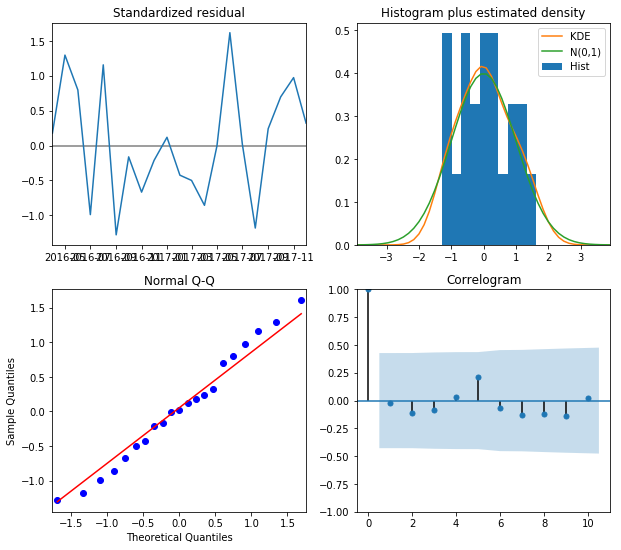

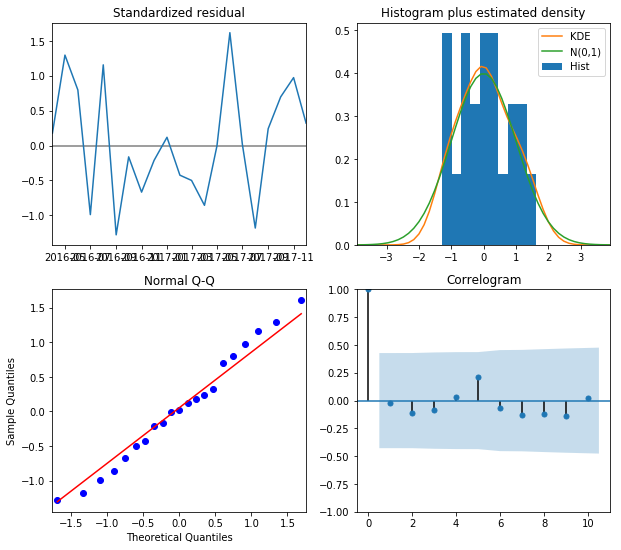

In [30]:
# Model Diganostics or SARIMA(3, 0, 0) on training set for monthly profits.
# Residuals look okay. 

results_300_profit_train.plot_diagnostics(figsize = (10, 9))

## Forecasting On Profits SARIMA(3, 0, 0)(1, 0, 0, 12)

In [31]:
# Obtain forecasts for 2019 from SARIMA(3, 0, 0):

forecasts_profits300 = results_300_profit_train.get_forecast(steps = 12)

forecasts_profits300.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,48336.371558,9629.005758,29463.867066,67208.876050
2018-02-01,50022.037564,10204.324803,30021.928464,70022.146665
2018-03-01,51674.874099,11182.131590,29758.298913,73591.449285
2018-04-01,51981.724393,12971.919919,26557.228542,77406.220245
2018-05-01,57526.523305,13991.189764,30104.295267,84948.751343
2018-06-01,65708.383568,15203.308187,35910.447075,95506.320062
2018-07-01,62009.230554,16540.046143,29591.335810,94427.125297
2018-08-01,65219.862969,17748.617788,30433.211328,100006.514609
2018-09-01,70508.573535,19037.925106,33194.925987,107822.221084
2018-10-01,74372.582725,20367.995849,34452.044423,114293.121026


In [32]:
# Obtain means from forecasts:

forecasts_mean_profits300 = forecasts_profits300.summary_frame()['mean']

forecasts_mean_profits300

2018-01-01    48336.371558
2018-02-01    50022.037564
2018-03-01    51674.874099
2018-04-01    51981.724393
2018-05-01    57526.523305
2018-06-01    65708.383568
2018-07-01    62009.230554
2018-08-01    65219.862969
2018-09-01    70508.573535
2018-10-01    74372.582725
2018-11-01    79125.328242
2018-12-01    82739.229076
Freq: MS, Name: mean, dtype: float64

### RMSE, Correlation & Mean Abs. Pct Error

In [33]:
# Root Mean Squared Error - Square of Predictions - Acutal (Test) Values:

mse_profit_300 = np.mean((forecasts_mean_profits300 - order_profits_mth_test)**2)

rmse_profit_300 = mse_profit_300 ** 0.5

rmse_profit_300

23224.836468658465

In [34]:
# Correlation Between Forecasted 2018 Values & Actual 2018 Sales Per Month

corr_profits_300 = np.corrcoef(forecasts_mean_profits300, order_profits_mth_test)

corr_profits_300

array([[1.        , 0.79613888],
       [0.79613888, 1.        ]])

In [35]:
# Mean Absolute Percentage Error

mean_abs_percent_error_profits_300 = np.mean(np.abs(forecasts_mean_profits300 - order_profits_mth_test)/np.abs(order_profits_mth_test)) 

mean_abs_percent_error_profits_300

0.6491705065964452

## Model Fit On Profits SARIMA(2, 0, 1)(0, 0, 0, 12)

In [36]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

sarima_201_profit_train = sm.tsa.statespace.SARIMAX(order_profits_mth_train,
                                       order = (2, 0, 1),
                                       seasonal_order = (0, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_201_profit_train = sarima_201_profit_train.fit()

print(results_201_profit_train.summary())

                           Statespace Model Results                           
Dep. Variable:                 Profit   No. Observations:                   36
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -358.345
Date:                Mon, 23 Sep 2019   AIC                            724.690
Time:                        00:29:31   BIC                            730.796
Sample:                    01-01-2015   HQIC                           726.773
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3792      0.188      7.326      0.000       1.010       1.748
ar.L2         -0.3563      0.188     -1.891      0.059      -0.726       0.013
ma.L1         -1.0264      0.240     -4.275      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


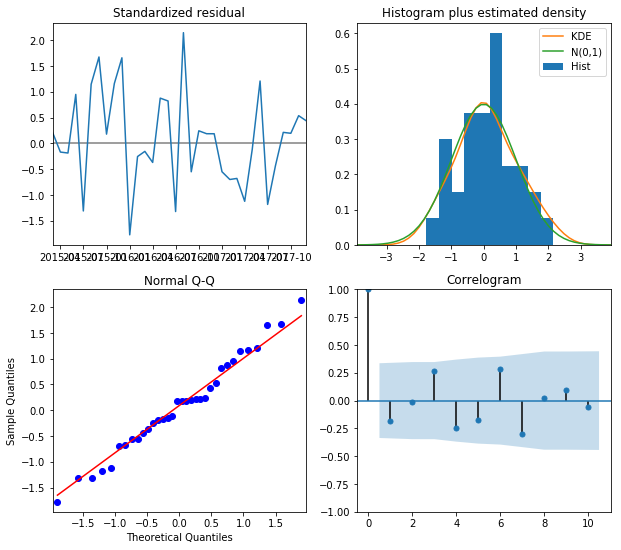

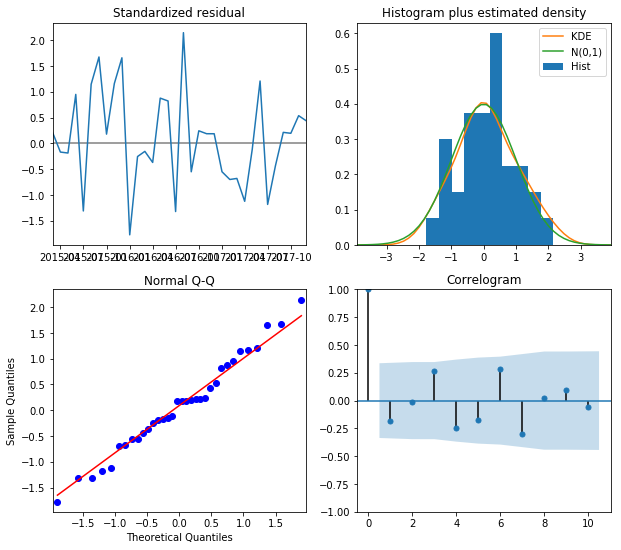

In [37]:
# Model Diganostics or SARIMA(2, 0, 1)(0, 0, 0, 12) on training set for monthly profits.
# Residuals look okay. 

results_201_profit_train.plot_diagnostics(figsize = (10, 9))

## Forecasting On Profits SARIMA(2, 0, 1)(0, 0, 0, 12)

In [38]:
# Obtain forecasts for 2019 from SARIMA(2, 0, 1)(0, 0, 0, 12):

forecasts_profits201 = results_201_profit_train.get_forecast(steps = 12)

forecasts_profits201.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,47781.164663,9933.949097,28310.982210,67251.347117
2018-02-01,48011.063839,10646.952262,27143.420860,68878.706818
2018-03-01,49191.118319,10792.503912,28038.199349,70344.037289
2018-04-01,50736.750392,10848.223158,29474.623706,71998.877078
2018-05-01,52448.008041,10885.447834,31112.922330,73783.093752
2018-06-01,54257.426832,10918.818938,32856.934960,75657.918703
2018-07-01,56143.211066,10952.366919,34676.966358,77609.455773
2018-08-01,58099.340533,10987.465276,36564.304310,79634.376756
2018-09-01,60125.278904,11024.678892,38517.305335,81733.252473
2018-10-01,62222.431759,11064.306047,40536.790393,83908.073125


In [39]:
# Obtain means from forecasts:

forecasts_mean_profits201 = forecasts_profits201.summary_frame()['mean']

forecasts_mean_profits201

2018-01-01    47781.164663
2018-02-01    48011.063839
2018-03-01    49191.118319
2018-04-01    50736.750392
2018-05-01    52448.008041
2018-06-01    54257.426832
2018-07-01    56143.211066
2018-08-01    58099.340533
2018-09-01    60125.278904
2018-10-01    62222.431759
2018-11-01    64392.928824
2018-12-01    66639.206585
Freq: MS, Name: mean, dtype: float64

### RMSE, Correlation & Mean Abs. Pct Error

In [40]:
# Root Mean Squared Error - Square of Predictions - Acutal (Test) Values:

mse_profit_201 = np.mean((forecasts_mean_profits201 - order_profits_mth_test)**2)

rmse_profit_201 = mse_profit_201 ** 0.5

rmse_profit_201

17767.436408790163

In [41]:
# Correlation Between Forecasted 2018 Values & Actual 2018 Sales Per Month

corr_profits_201 = np.corrcoef(forecasts_mean_profits201, order_profits_mth_test)

corr_profits_201

array([[1.        , 0.78687626],
       [0.78687626, 1.        ]])

In [42]:
# Mean Absolute Percentage Error

mean_abs_percent_error_profits_201 = np.mean(np.abs(forecasts_mean_profits201 - order_profits_mth_test)/np.abs(order_profits_mth_test)) 

mean_abs_percent_error_profits_201

0.5073559564149276

# SARIMA(2, 0, 1)(0, 0, 0, 12)  For Monthly Profits

The SARIMA(1, 0, 0)(0, 0, 0, 12) model has a lower mean absolute percentage error than the SARIMA(3, 0, 0)(1, 0, 0, 12) model and the SARIMA(2, 0, 1)(0, 0, 0, 12) model. 

What puzzles me is hte negative correlation between predicted values and test values for 2018 for the SARIMA(1, 0, 0)(0, 0, 0, 12) model. The next best model would be the SARIMA(2, 0, 1)(0, 0, 0, 12) model.

Put chart of model diagnostics.

## SARIMA Model Fit

Fitting the SARIMA Model(2, 0, 1) x (0, 0, 0, 12) on the monthly order profits.

In [43]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

sarima_profits_201 = sm.tsa.statespace.SARIMAX(order_profits_monthly,
                                       order = (2, 0, 1),
                                       seasonal_order = (0, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_profits_201 = sarima_profits_201.fit()

print(results_profits_201.summary())

                           Statespace Model Results                           
Dep. Variable:                 Profit   No. Observations:                   48
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -490.082
Date:                Mon, 23 Sep 2019   AIC                            988.164
Time:                        00:29:33   BIC                            995.479
Sample:                    01-01-2015   HQIC                           990.904
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4074      0.161      8.718      0.000       1.091       1.724
ar.L2         -0.3900      0.164     -2.383      0.017      -0.711      -0.069
ma.L1         -1.0168      0.167     -6.090      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## Forecasts On Overall Monthly Profits

In [44]:
forecasts_profits201 = results_profits_201.get_forecast(steps = 12)

forecasts_profits201.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,51867.434485,11258.053979,29802.054149,73932.814820
2019-02-01,54702.071071,12172.529510,30844.351630,78559.790511
2019-03-01,56760.719386,12358.271939,32538.951475,80982.487298
2019-04-01,58552.590321,12417.738828,34214.269450,82890.911193
2019-05-01,60271.635006,12449.426483,35871.207472,84672.062541
2019-06-01,61992.228190,12473.890672,37543.851726,86440.604654
2019-07-01,63743.404038,12496.657196,39250.406007,88236.402068
2019-08-01,65537.019134,12519.555572,40999.141110,90074.897157
2019-09-01,67378.437150,12543.285618,42794.049091,91962.825210
2019-10-01,69270.582887,12568.153292,44637.455084,93903.710691


In [45]:
# Obtain means from forecasts:

forecasts_meanprofits201 = forecasts_profits201.summary_frame()['mean']

forecasts_meanprofits201

2019-01-01    51867.434485
2019-02-01    54702.071071
2019-03-01    56760.719386
2019-04-01    58552.590321
2019-05-01    60271.635006
2019-06-01    61992.228190
2019-07-01    63743.404038
2019-08-01    65537.019134
2019-09-01    67378.437150
2019-10-01    69270.582887
2019-11-01    71215.480911
2019-12-01    73214.839960
Freq: MS, Name: mean, dtype: float64

In [46]:
# Monthly profits before 2019:

monthly_profits_pre2019 = order_profits_monthly[order_profits_monthly.index < '2019-01-01']

monthly_profits_pre2019.tail()

Order_Date_Month
2018-08-01    53542.89496
2018-09-01    67979.45110
2018-10-01    58209.83476
2018-11-01    62856.58790
2018-12-01    46916.52068
Name: Profit, dtype: float64

In [47]:
# Monthly sales before 2019 and including the forecasted 
# January 2019 sales (to connect lines in plot)

monthly_profits_pre2019 = monthly_profits_pre2019.append(forecasts_meanprofits201.head(1))

monthly_profits_pre2019.tail()

2018-09-01    67979.451100
2018-10-01    58209.834760
2018-11-01    62856.587900
2018-12-01    46916.520680
2019-01-01    51867.434485
dtype: float64

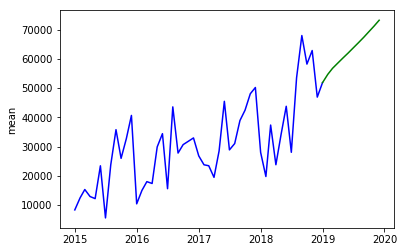

In [48]:
# Line Plots (Blue is historical data, green is forecasted)

sns.lineplot(x = monthly_profits_pre2019.index, y = monthly_profits_pre2019, color = 'blue')
sns.lineplot(x = forecasts_meanprofits201.index, y = forecasts_meanprofits201, color = 'green')
#plt.axvline(pd.Timestamp('2019-01-01'), color= 'green', alpha = 0.5)

The green forecast is too smooth. It does not look realistic. I think it is because in the SARIMA(2, 0, 1) x (0, 0, 0, 12) model there is no seasonality component. Even though the AIC, BIC and prediction metrics look good but this forecasts looks awful from context.

I will try a different model.

# Trying SARIMA(3, 0, 0)(1, 0, 0, 12) As Final Model For Monthly Profits

In [49]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

sarima_profits_300 = sm.tsa.statespace.SARIMAX(order_profits_monthly,
                                       order = (3, 0, 0),
                                       seasonal_order = (1, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_profits_300 = sarima_profits_300.fit()

print(results_profits_300.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             Profit   No. Observations:                   48
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -351.134
Date:                            Mon, 23 Sep 2019   AIC                            712.269
Time:                                    00:29:33   BIC                            719.751
Sample:                                01-01-2015   HQIC                           714.787
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5423      0.199      2.720      0.007       0.152       0.933
ar.L2          0.1648      0.287   

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [50]:
# Obtain monthly order profits on forecastsL

forecasts_profits300 = results_profits_300.get_forecast(steps = 12)

forecasts_profits300.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,42403.129684,11021.357804,20801.665327,64004.594042
2019-02-01,39541.236978,12537.816135,14967.568908,64114.905048
2019-03-01,45372.458657,13519.413576,18874.894956,71870.022358
2019-04-01,39040.655179,15105.275307,9434.859601,68646.450758
2019-05-01,44164.093072,16297.821648,12220.949617,76107.236528
2019-06-01,48353.997883,17302.497267,14441.726398,82266.269369
2019-07-01,40294.303299,18313.056617,4401.371884,76187.234714
2019-08-01,52723.446993,19234.543763,15024.433958,90422.460028
2019-09-01,59535.464948,20079.985352,20179.416848,98891.513049
2019-10-01,54392.456806,20882.699616,13463.117659,95321.795952


In [51]:
# Obtain means from forecasts:

forecasts_meanprofits300 = forecasts_profits300.summary_frame()['mean']

forecasts_meanprofits300

2019-01-01    42403.129684
2019-02-01    39541.236978
2019-03-01    45372.458657
2019-04-01    39040.655179
2019-05-01    44164.093072
2019-06-01    48353.997883
2019-07-01    40294.303299
2019-08-01    52723.446993
2019-09-01    59535.464948
2019-10-01    54392.456806
2019-11-01    56417.984775
2019-12-01    48212.528523
Freq: MS, Name: mean, dtype: float64

In [52]:
# Monthly profits before 2019:

monthly_profits_pre2019 = order_profits_monthly[order_profits_monthly.index < '2019-01-01']

monthly_profits_pre2019.tail()

Order_Date_Month
2018-08-01    53542.89496
2018-09-01    67979.45110
2018-10-01    58209.83476
2018-11-01    62856.58790
2018-12-01    46916.52068
Name: Profit, dtype: float64

In [53]:
# Monthly sales before 2019 and including the forecasted 
# January 2019 sales (to connect lines in plot)

monthly_profits_pre2019 = monthly_profits_pre2019.append(forecasts_meanprofits300.head(1))

monthly_profits_pre2019.tail()

2018-09-01    67979.451100
2018-10-01    58209.834760
2018-11-01    62856.587900
2018-12-01    46916.520680
2019-01-01    42403.129684
dtype: float64

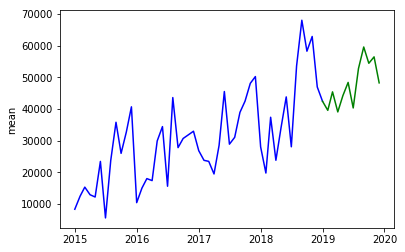

In [54]:
# Line Plots (Blue is historical data, green is forecasted)

sns.lineplot(x = monthly_profits_pre2019.index, y = monthly_profits_pre2019, color = 'blue')
sns.lineplot(x = forecasts_meanprofits300.index, y = forecasts_meanprofits300, color = 'green')
#plt.axvline(pd.Timestamp('2019-01-01'), color= 'green', alpha = 0.5)